In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import tqdm.notebook as tqdm

data = pd.read_csv("data/random_test/5528_data.csv")
data = data.dropna()
data.sort_values('created_at')

# Use multi features for multivariate modeling
target = data[['imbalance_health']]
data = data[['vel_crest_factor_x','rms_x','vel_kurtosis_y','vel_kurtosis_z','vel_crest_factor_y']]

# Show the head of the data
print(data.head())
print(target.head())

   vel_crest_factor_x     rms_x  vel_kurtosis_y  vel_kurtosis_z  \
0             3.17691  0.016531        0.238311       -0.194781   
1             3.02361  0.163692       -0.332250       -0.207113   
2             3.48348  0.012110        0.134024        0.313288   
3             3.15218  0.011488       -0.642477       -0.035853   
4             3.13313  0.180281       -0.224277       -0.048955   

   vel_crest_factor_y  
0             3.07878  
1             3.06249  
2             3.35456  
3             2.62286  
4             3.47616  
   imbalance_health
0          0.924009
1          0.924009
2          0.924009
3          0.924009
4          0.924009


In [25]:
# Normalize the entire dataset (all features)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values)

# Target column (Close) for comparison
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target.values)

In [26]:
type(data_scaled), data_scaled.shape

(numpy.ndarray, (2515, 5))

In [27]:
type(target_scaled), target_scaled.shape

(numpy.ndarray, (2515, 1))

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

epochs = 500
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the function to create sequences
def create_sequences_multivariate(data, target, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append((seq, label))
    return sequences

# Define the model
class MultivariateLSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=100, output_size=1):
        super(MultivariateLSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Training function
def train_model(model, train_loader, epochs=10, lr=0.001, device='cpu', save_path='best_model.pth'):
    model.to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    min_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        for seq, labels in train_loader:
            seq = seq.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        average_loss = epoch_loss / len(train_loader)
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.6f}')
        if average_loss < min_loss:
            min_loss = average_loss
            torch.save(model.state_dict(), save_path)
            # print(f'Saved model with lowest loss: {min_loss:.6f}')

# Evaluation function
def evaluate_model(model, test_loader, target_scaler, model_path='best_model.pth', device='cpu'):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for seq, labels in test_loader:
            seq = seq.to(device)
            labels = labels.to(device)
            y_pred = model(seq)
            predictions.append(y_pred.cpu().numpy())
            actuals.append(labels.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    predictions = target_scaler.inverse_transform(predictions)
    actuals = target_scaler.inverse_transform(actuals)
    return predictions, actuals

# Plot function
def plot_predictions(predictions, actuals, num_plots=100, filename='plot.png'):
    plt.figure(figsize=(12, 6))
    plt.plot(actuals[:num_plots], label='Actual Value', color='blue')
    plt.plot(predictions[:num_plots], label='Predicted Value', color='red')
    plt.title('Prediction vs Actual Values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig(filename)
    plt.close()

# Main loop for different SEQ_LENGTH values
seq_lengths = range(2, 31)
for SEQ_LENGTH in tqdm.tqdm(seq_lengths):
    print(f'\nProcessing SEQ_LENGTH={SEQ_LENGTH}...')
    
    # Create sequences
    sequences = create_sequences_multivariate(data_scaled, target_scaled, SEQ_LENGTH)
    
    # Split into training and testing datasets
    train_size = int(len(sequences) * 0.8)
    train_sequences = sequences[:train_size]
    test_sequences = sequences[train_size:]
    
    # Unpack sequences into tensors
    train_sequences_features = [seq for seq, label in train_sequences]
    train_sequences_labels = [label for seq, label in train_sequences]
    test_sequences_features = [seq for seq, label in test_sequences]
    test_sequences_labels = [label for seq, label in test_sequences]
    
    # Convert lists to tensors
    train_features_tensor = torch.stack([torch.Tensor(x) for x in train_sequences_features])
    train_labels_tensor = torch.stack([torch.Tensor(x) for x in train_sequences_labels])
    test_features_tensor = torch.stack([torch.Tensor(x) for x in test_sequences_features])
    test_labels_tensor = torch.stack([torch.Tensor(x) for x in test_sequences_labels])
    
    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
    test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
    train_loader = DataLoader(dataset=train_dataset, batch_size=12, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=12, shuffle=False)
    
    # Initialize and train the model
    multivariate_model = MultivariateLSTMModel(input_size=train_features_tensor.shape[2])
    print("Starting training...")
    train_model(multivariate_model, train_loader, epochs=500, lr=0.001, device=device)
    
    # Evaluate the model
    print("Evaluating the model...")
    predictions, actuals = evaluate_model(multivariate_model, test_loader, target_scaler, device=device)
    
    # Plot and save results
    filename = f'plot_seq_length_{SEQ_LENGTH}.png'
    print(f"Saving plot as {filename}...")
    plot_predictions(predictions, actuals, num_plots=5000, filename=filename)

    print(f"Completed SEQ_LENGTH={SEQ_LENGTH}.\n")


  0%|          | 0/29 [00:00<?, ?it/s]


Processing SEQ_LENGTH=2...
Starting training...
Epoch 50/500, Loss: 0.015279
Epoch 100/500, Loss: 0.014559
Epoch 150/500, Loss: 0.014612
Epoch 200/500, Loss: 0.014497
Epoch 250/500, Loss: 0.014521
Epoch 300/500, Loss: 0.014261
Epoch 350/500, Loss: 0.014143
Epoch 400/500, Loss: 0.013803
Epoch 450/500, Loss: 0.014035
Epoch 500/500, Loss: 0.013338
Evaluating the model...
Saving plot as plot_seq_length_2.png...
Completed SEQ_LENGTH=2.


Processing SEQ_LENGTH=3...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014459
Epoch 100/500, Loss: 0.014415
Epoch 150/500, Loss: 0.014395
Epoch 200/500, Loss: 0.014289
Epoch 250/500, Loss: 0.014129
Epoch 300/500, Loss: 0.013405
Epoch 350/500, Loss: 0.012596
Epoch 400/500, Loss: 0.011766
Epoch 450/500, Loss: 0.011271
Epoch 500/500, Loss: 0.010316
Evaluating the model...
Saving plot as plot_seq_length_3.png...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Completed SEQ_LENGTH=3.


Processing SEQ_LENGTH=4...
Starting training...
Epoch 50/500, Loss: 0.014769
Epoch 100/500, Loss: 0.014558
Epoch 150/500, Loss: 0.014340
Epoch 200/500, Loss: 0.013985
Epoch 250/500, Loss: 0.013137
Epoch 300/500, Loss: 0.012444
Epoch 350/500, Loss: 0.011622
Epoch 400/500, Loss: 0.010826
Epoch 450/500, Loss: 0.008995
Epoch 500/500, Loss: 0.007893
Evaluating the model...
Saving plot as plot_seq_length_4.png...
Completed SEQ_LENGTH=4.


Processing SEQ_LENGTH=5...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014879
Epoch 100/500, Loss: 0.014420
Epoch 150/500, Loss: 0.014361
Epoch 200/500, Loss: 0.013658
Epoch 250/500, Loss: 0.012549
Epoch 300/500, Loss: 0.012306
Epoch 350/500, Loss: 0.010290
Epoch 400/500, Loss: 0.008334
Epoch 450/500, Loss: 0.005610
Epoch 500/500, Loss: 0.003577
Evaluating the model...
Saving plot as plot_seq_length_5.png...
Completed SEQ_LENGTH=5.


Processing SEQ_LENGTH=6...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014509
Epoch 100/500, Loss: 0.014342
Epoch 150/500, Loss: 0.014229
Epoch 200/500, Loss: 0.014230
Epoch 250/500, Loss: 0.013428
Epoch 300/500, Loss: 0.012124
Epoch 350/500, Loss: 0.011387
Epoch 400/500, Loss: 0.007773
Epoch 450/500, Loss: 0.005665
Epoch 500/500, Loss: 0.003955
Evaluating the model...
Saving plot as plot_seq_length_6.png...
Completed SEQ_LENGTH=6.


Processing SEQ_LENGTH=7...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014485
Epoch 100/500, Loss: 0.014281
Epoch 150/500, Loss: 0.014371
Epoch 200/500, Loss: 0.014249
Epoch 250/500, Loss: 0.014018
Epoch 300/500, Loss: 0.010076
Epoch 350/500, Loss: 0.007365
Epoch 400/500, Loss: 0.003623
Epoch 450/500, Loss: 0.001455
Epoch 500/500, Loss: 0.008342
Evaluating the model...
Saving plot as plot_seq_length_7.png...
Completed SEQ_LENGTH=7.


Processing SEQ_LENGTH=8...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014527
Epoch 100/500, Loss: 0.014425
Epoch 150/500, Loss: 0.014214
Epoch 200/500, Loss: 0.016680
Epoch 250/500, Loss: 0.014095
Epoch 300/500, Loss: 0.011142
Epoch 350/500, Loss: 0.005557
Epoch 400/500, Loss: 0.002335
Epoch 450/500, Loss: 0.000947
Epoch 500/500, Loss: 0.000463
Evaluating the model...
Saving plot as plot_seq_length_8.png...
Completed SEQ_LENGTH=8.


Processing SEQ_LENGTH=9...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014523
Epoch 100/500, Loss: 0.014445
Epoch 150/500, Loss: 0.014347
Epoch 200/500, Loss: 0.014180
Epoch 250/500, Loss: 0.012160
Epoch 300/500, Loss: 0.006499
Epoch 350/500, Loss: 0.002734
Epoch 400/500, Loss: 0.000844
Epoch 450/500, Loss: 0.000430
Epoch 500/500, Loss: 0.001271
Evaluating the model...
Saving plot as plot_seq_length_9.png...
Completed SEQ_LENGTH=9.


Processing SEQ_LENGTH=10...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014514
Epoch 100/500, Loss: 0.014515
Epoch 150/500, Loss: 0.014319
Epoch 200/500, Loss: 0.014288
Epoch 250/500, Loss: 0.009131
Epoch 300/500, Loss: 0.003457
Epoch 350/500, Loss: 0.001799
Epoch 400/500, Loss: 0.000353
Epoch 450/500, Loss: 0.000601
Epoch 500/500, Loss: 0.000063
Evaluating the model...
Saving plot as plot_seq_length_10.png...
Completed SEQ_LENGTH=10.


Processing SEQ_LENGTH=11...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014472
Epoch 100/500, Loss: 0.014415
Epoch 150/500, Loss: 0.014344
Epoch 200/500, Loss: 0.012689
Epoch 250/500, Loss: 0.010178
Epoch 300/500, Loss: 0.003808
Epoch 350/500, Loss: 0.001427
Epoch 400/500, Loss: 0.000505
Epoch 450/500, Loss: 0.002546
Epoch 500/500, Loss: 0.000144
Evaluating the model...
Saving plot as plot_seq_length_11.png...
Completed SEQ_LENGTH=11.


Processing SEQ_LENGTH=12...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014578
Epoch 100/500, Loss: 0.014416
Epoch 150/500, Loss: 0.014326
Epoch 200/500, Loss: 0.014296
Epoch 250/500, Loss: 0.004792
Epoch 300/500, Loss: 0.001981
Epoch 350/500, Loss: 0.000725
Epoch 400/500, Loss: 0.000257
Epoch 450/500, Loss: 0.000240
Epoch 500/500, Loss: 0.000765
Evaluating the model...
Saving plot as plot_seq_length_12.png...
Completed SEQ_LENGTH=12.


Processing SEQ_LENGTH=13...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014527
Epoch 100/500, Loss: 0.014338
Epoch 150/500, Loss: 0.014295
Epoch 200/500, Loss: 0.012621
Epoch 250/500, Loss: 0.007045
Epoch 300/500, Loss: 0.002400
Epoch 350/500, Loss: 0.000849
Epoch 400/500, Loss: 0.000282
Epoch 450/500, Loss: 0.000050
Epoch 500/500, Loss: 0.000062
Evaluating the model...
Saving plot as plot_seq_length_13.png...
Completed SEQ_LENGTH=13.


Processing SEQ_LENGTH=14...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014535
Epoch 100/500, Loss: 0.014401
Epoch 150/500, Loss: 0.013929
Epoch 200/500, Loss: 0.012330
Epoch 250/500, Loss: 0.011163
Epoch 300/500, Loss: 0.007578
Epoch 350/500, Loss: 0.002732
Epoch 400/500, Loss: 0.000578
Epoch 450/500, Loss: 0.000232
Epoch 500/500, Loss: 0.000176
Evaluating the model...
Saving plot as plot_seq_length_14.png...
Completed SEQ_LENGTH=14.


Processing SEQ_LENGTH=15...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014512
Epoch 100/500, Loss: 0.014379
Epoch 150/500, Loss: 0.012409
Epoch 200/500, Loss: 0.010950
Epoch 250/500, Loss: 0.008951
Epoch 300/500, Loss: 0.002652
Epoch 350/500, Loss: 0.001492
Epoch 400/500, Loss: 0.000280
Epoch 450/500, Loss: 0.000045
Epoch 500/500, Loss: 0.001252
Evaluating the model...
Saving plot as plot_seq_length_15.png...
Completed SEQ_LENGTH=15.


Processing SEQ_LENGTH=16...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014562
Epoch 100/500, Loss: 0.014336
Epoch 150/500, Loss: 0.013501
Epoch 200/500, Loss: 0.007050
Epoch 250/500, Loss: 0.002329
Epoch 300/500, Loss: 0.001009
Epoch 350/500, Loss: 0.000458
Epoch 400/500, Loss: 0.000163
Epoch 450/500, Loss: 0.000062
Epoch 500/500, Loss: 0.000024
Evaluating the model...
Saving plot as plot_seq_length_16.png...
Completed SEQ_LENGTH=16.


Processing SEQ_LENGTH=17...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014750
Epoch 100/500, Loss: 0.014345
Epoch 150/500, Loss: 0.013371
Epoch 200/500, Loss: 0.010803
Epoch 250/500, Loss: 0.003996
Epoch 300/500, Loss: 0.001140
Epoch 350/500, Loss: 0.000455
Epoch 400/500, Loss: 0.000202
Epoch 450/500, Loss: 0.000063
Epoch 500/500, Loss: 0.000043
Evaluating the model...
Saving plot as plot_seq_length_17.png...
Completed SEQ_LENGTH=17.


Processing SEQ_LENGTH=18...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014434
Epoch 100/500, Loss: 0.014198
Epoch 150/500, Loss: 0.011696
Epoch 200/500, Loss: 0.009487
Epoch 250/500, Loss: 0.005046
Epoch 300/500, Loss: 0.001053
Epoch 350/500, Loss: 0.000586
Epoch 400/500, Loss: 0.002989
Epoch 450/500, Loss: 0.000041
Epoch 500/500, Loss: 0.000035
Evaluating the model...
Saving plot as plot_seq_length_18.png...
Completed SEQ_LENGTH=18.


Processing SEQ_LENGTH=19...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014485
Epoch 100/500, Loss: 0.014203
Epoch 150/500, Loss: 0.014266
Epoch 200/500, Loss: 0.012858
Epoch 250/500, Loss: 0.007961
Epoch 300/500, Loss: 0.003667
Epoch 350/500, Loss: 0.003165
Epoch 400/500, Loss: 0.000655
Epoch 450/500, Loss: 0.000370
Epoch 500/500, Loss: 0.000744
Evaluating the model...
Saving plot as plot_seq_length_19.png...
Completed SEQ_LENGTH=19.


Processing SEQ_LENGTH=20...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014428
Epoch 100/500, Loss: 0.014184
Epoch 150/500, Loss: 0.012080
Epoch 200/500, Loss: 0.007091
Epoch 250/500, Loss: 0.002217
Epoch 300/500, Loss: 0.001066
Epoch 350/500, Loss: 0.000596
Epoch 400/500, Loss: 0.000143
Epoch 450/500, Loss: 0.000137
Epoch 500/500, Loss: 0.000068
Evaluating the model...
Saving plot as plot_seq_length_20.png...
Completed SEQ_LENGTH=20.


Processing SEQ_LENGTH=21...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.015225
Epoch 100/500, Loss: 0.013156
Epoch 150/500, Loss: 0.012037
Epoch 200/500, Loss: 0.005330
Epoch 250/500, Loss: 0.001706
Epoch 300/500, Loss: 0.000623
Epoch 350/500, Loss: 0.000319
Epoch 400/500, Loss: 0.000062
Epoch 450/500, Loss: 0.000107
Epoch 500/500, Loss: 0.000021
Evaluating the model...
Saving plot as plot_seq_length_21.png...
Completed SEQ_LENGTH=21.


Processing SEQ_LENGTH=22...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014963
Epoch 100/500, Loss: 0.013165
Epoch 150/500, Loss: 0.011367
Epoch 200/500, Loss: 0.005718
Epoch 250/500, Loss: 0.002208
Epoch 300/500, Loss: 0.000706
Epoch 350/500, Loss: 0.000399
Epoch 400/500, Loss: 0.000236
Epoch 450/500, Loss: 0.000327
Epoch 500/500, Loss: 0.000036
Evaluating the model...
Saving plot as plot_seq_length_22.png...
Completed SEQ_LENGTH=22.


Processing SEQ_LENGTH=23...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014541
Epoch 100/500, Loss: 0.012853
Epoch 150/500, Loss: 0.014786
Epoch 200/500, Loss: 0.014597
Epoch 250/500, Loss: 0.014347
Epoch 300/500, Loss: 0.006891
Epoch 350/500, Loss: 0.004983
Epoch 400/500, Loss: 0.004323
Epoch 450/500, Loss: 0.002666
Epoch 500/500, Loss: 0.000628
Evaluating the model...
Saving plot as plot_seq_length_23.png...
Completed SEQ_LENGTH=23.


Processing SEQ_LENGTH=24...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014521
Epoch 100/500, Loss: 0.012646
Epoch 150/500, Loss: 0.004235
Epoch 200/500, Loss: 0.001956
Epoch 250/500, Loss: 0.000592
Epoch 300/500, Loss: 0.000141
Epoch 350/500, Loss: 0.000185
Epoch 400/500, Loss: 0.000074
Epoch 450/500, Loss: 0.000178
Epoch 500/500, Loss: 0.000041
Evaluating the model...
Saving plot as plot_seq_length_24.png...
Completed SEQ_LENGTH=24.


Processing SEQ_LENGTH=25...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014639
Epoch 100/500, Loss: 0.013674
Epoch 150/500, Loss: 0.005855
Epoch 200/500, Loss: 0.002869
Epoch 250/500, Loss: 0.000385
Epoch 300/500, Loss: 0.000210
Epoch 350/500, Loss: 0.000202
Epoch 400/500, Loss: 0.000358
Epoch 450/500, Loss: 0.000019
Epoch 500/500, Loss: 0.000015
Evaluating the model...
Saving plot as plot_seq_length_25.png...
Completed SEQ_LENGTH=25.


Processing SEQ_LENGTH=26...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014743
Epoch 100/500, Loss: 0.013299
Epoch 150/500, Loss: 0.006194
Epoch 200/500, Loss: 0.002573
Epoch 250/500, Loss: 0.001157
Epoch 300/500, Loss: 0.000242
Epoch 350/500, Loss: 0.000085
Epoch 400/500, Loss: 0.000088
Epoch 450/500, Loss: 0.000037
Epoch 500/500, Loss: 0.000030
Evaluating the model...
Saving plot as plot_seq_length_26.png...
Completed SEQ_LENGTH=26.


Processing SEQ_LENGTH=27...
Starting training...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Epoch 50/500, Loss: 0.014703
Epoch 100/500, Loss: 0.013576
Epoch 150/500, Loss: 0.005067
Epoch 200/500, Loss: 0.003676
Epoch 250/500, Loss: 0.004466
Epoch 300/500, Loss: 0.001165
Epoch 350/500, Loss: 0.002121
Epoch 400/500, Loss: 0.000319
Epoch 450/500, Loss: 0.000315
Epoch 500/500, Loss: 0.000068
Evaluating the model...
Saving plot as plot_seq_length_27.png...
Completed SEQ_LENGTH=27.


Processing SEQ_LENGTH=28...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014569
Epoch 100/500, Loss: 0.012472
Epoch 150/500, Loss: 0.003798
Epoch 200/500, Loss: 0.001857
Epoch 250/500, Loss: 0.000552
Epoch 300/500, Loss: 0.000253
Epoch 350/500, Loss: 0.000301
Epoch 400/500, Loss: 0.000152
Epoch 450/500, Loss: 0.001071
Epoch 500/500, Loss: 0.000158
Evaluating the model...
Saving plot as plot_seq_length_28.png...
Completed SEQ_LENGTH=28.


Processing SEQ_LENGTH=29...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014740
Epoch 100/500, Loss: 0.010278
Epoch 150/500, Loss: 0.003936
Epoch 200/500, Loss: 0.002036
Epoch 250/500, Loss: 0.000519
Epoch 300/500, Loss: 0.000377
Epoch 350/500, Loss: 0.000138
Epoch 400/500, Loss: 0.000040
Epoch 450/500, Loss: 0.002136
Epoch 500/500, Loss: 0.000012
Evaluating the model...
Saving plot as plot_seq_length_29.png...
Completed SEQ_LENGTH=29.


Processing SEQ_LENGTH=30...


C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Starting training...
Epoch 50/500, Loss: 0.014610
Epoch 100/500, Loss: 0.010517
Epoch 150/500, Loss: 0.004065
Epoch 200/500, Loss: 0.001806
Epoch 250/500, Loss: 0.000509
Epoch 300/500, Loss: 0.000167
Epoch 350/500, Loss: 0.000523
Epoch 400/500, Loss: 0.000030
Epoch 450/500, Loss: 0.000014
Epoch 500/500, Loss: 0.000012
Evaluating the model...
Saving plot as plot_seq_length_30.png...
Completed SEQ_LENGTH=30.



C:\Users\user\AppData\Local\Temp\ipykernel_5896\288807071.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

In [62]:
# Create sequences for training and testing
def create_sequences_multivariate(data, target, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append((seq, label))
    return sequences
    
SEQ_LENGTH = 12  # Use the past 12 sequence to predict the one day
sequences = create_sequences_multivariate(data_scaled, target_scaled, SEQ_LENGTH)

In [63]:
# Split into training and testing datasets (80% train, 20% test)
train_size = int(len(sequences) * 0.8)
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]

type(train_sequences), type(test_sequences)

(list, list)

In [64]:
# Unpack the sequences into separate tensors for features and labels
train_sequences_features = [seq for seq, label in train_sequences]
train_sequences_labels = [label for seq, label in train_sequences]

test_sequences_features = [seq for seq, label in test_sequences]
test_sequences_labels = [label for seq, label in test_sequences]

 # Convert lists to tensors and reshape
train_features_tensor = torch.stack([torch.Tensor(x) for x in train_sequences_features])
train_labels_tensor = torch.stack([torch.Tensor(x) for x in train_sequences_labels])

test_features_tensor = torch.stack([torch.Tensor(x) for x in test_sequences_features])
test_labels_tensor = torch.stack([torch.Tensor(x) for x in test_sequences_labels])

In [65]:
# Create TensorDatasets for training and testing
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

# Create DataLoaders for training and testing datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=12, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=12, shuffle=False)

In [66]:
# Step 3: Build the Multivariate LSTM Model
class MultivariateLSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=100, output_size=1):
        super(MultivariateLSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Use the output from the last time step
        return predictions

In [67]:
def train_model(model, train_loader, epochs=10, lr=0.001, device='cpu', save_path='best_model.pth'):
    model.to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    min_loss = float('inf')  # Initialize min_loss to infinity
    for epoch in range(epochs):
        epoch_loss = 0
        for seq, labels in train_loader:
            seq = seq.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        average_loss = epoch_loss / len(train_loader)
        if (epoch+1) % 50 == 0 :
            print(f'Epoch {epoch+1}/{epochs}, Loss: {average_loss:.6f}')

        # Check if the current average loss is less than the minimum loss
        if average_loss < min_loss:
            min_loss = average_loss
            torch.save(model.state_dict(), save_path)  # Save the model with the lowest loss
            print(f'Saved model with lowest loss: {min_loss:.6f}')

In [68]:
# Step 5: Evaluate the Model
def evaluate_model(model, test_loader, target_scaler, model_path='best_model.pth', device='cpu'):
    # Load the model parameter
    with open('best_model.pth', 'rb') as f:
        model.load_state_dict(torch.load(f))
    # model.load_state_dict(torch.load(model_path,  map_location=device))
    model.to(device)
    model.eval()

    predictions = []
    actuals = []

    with torch.no_grad():
        for seq, labels in test_loader:
            seq = seq.to(device)
            labels = labels.to(device)

            y_pred = model(seq)
            predictions.append(y_pred.cpu().numpy())
            actuals.append(labels.cpu().numpy())

    # Concatenate all batches
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Inverse transform to original scale
    predictions = target_scaler.inverse_transform(predictions)
    actuals = target_scaler.inverse_transform(actuals)

    return predictions, actuals


In [69]:
def plot_predictions(predictions, actuals, num_plots=100):
    plt.figure(figsize=(12,6))
    plt.plot(actuals[:num_plots], label='Actual Value', color='blue')
    plt.plot(predictions[:num_plots], label='Predicted Value', color='red')
    plt.title(f'{data.columns.tolist()} Prediction')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [70]:
epochs = 500
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Preprocess Data for Multivariate Model
scaler_multi, target_scaler_multi, train_loader_multi, test_loader_multi = scaler, target_scaler, train_loader, test_loader
print("Multivariate data preprocessing completed.")

# Initialize the Multivariate Model
multivariate_model = MultivariateLSTMModel(input_size=5)  # Input size is 5 (Open, High, Low, Close, Volume)
print("Multivariate model initialized.")

Using device: cuda
Multivariate data preprocessing completed.
Multivariate model initialized.


In [71]:
# Train the Multivariate Model
print("Starting multivariate model training...")
train_model(multivariate_model, train_loader_multi, epochs, lr, device)
print("Multivariate model training completed.")

Starting multivariate model training...
Saved model with lowest loss: 0.090670
Saved model with lowest loss: 0.015335
Saved model with lowest loss: 0.015131
Saved model with lowest loss: 0.014845
Saved model with lowest loss: 0.014824
Saved model with lowest loss: 0.014680
Saved model with lowest loss: 0.014640
Saved model with lowest loss: 0.014614
Saved model with lowest loss: 0.014605
Saved model with lowest loss: 0.014495
Saved model with lowest loss: 0.014488
Epoch 50/500, Loss: 0.014747
Saved model with lowest loss: 0.014439
Saved model with lowest loss: 0.014394
Saved model with lowest loss: 0.014385
Saved model with lowest loss: 0.014345
Saved model with lowest loss: 0.014319
Saved model with lowest loss: 0.014269
Epoch 100/500, Loss: 0.014344
Saved model with lowest loss: 0.014249
Saved model with lowest loss: 0.014222
Saved model with lowest loss: 0.014202
Saved model with lowest loss: 0.014186
Saved model with lowest loss: 0.014097
Saved model with lowest loss: 0.014048
Epoc

Evaluating the multivariate model...
Multivariate model evaluation completed.
Plotting the results...


C:\Users\user\AppData\Local\Temp\ipykernel_2148\2747113322.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f))


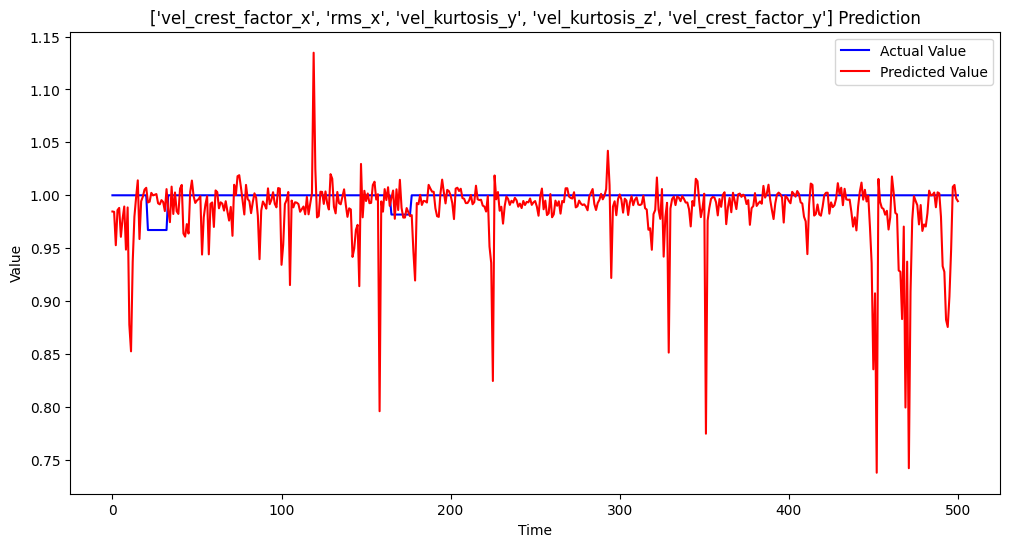

In [72]:
# Evaluate the Multivariate Model
print("Evaluating the multivariate model...")
predictions_multi, actuals_multi = evaluate_model(multivariate_model, test_loader_multi, target_scaler_multi, device)
print("Multivariate model evaluation completed.")
print("Plotting the results...")
plot_predictions(predictions_multi, actuals_multi, num_plots=5000)